In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.svm import SVC
import pandas as pd
import pickle
from collections import Counter
from bs4 import BeautifulSoup as bs
import re,csv, os, itertools, pandas as pd,docx2txt
from tqdm import tqdm
from pattern.web import PDF
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
from spacy.lang.id import Indonesian
from html import unescape
from unidecode import unidecode
from bz2 import BZ2File as bz2
from textblob import TextBlob
import spacy
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

def LoadStopWords(lang):
    L = lang.lower().strip()
    if L == 'en' or L == 'english' or L == 'inggris':
        lemmatizer = WordNetLemmatizer()
        stops =  set([t.strip() for t in LoadDocuments(file = 'C:/WinPython_64bit/notebooks/Google-Play-Store-Review-Extractor-master/stopwords_eng.txt')[0]])
    elif L == 'id' or L == 'indonesia' or L=='indonesian':
        lemmatizer = Indonesian() 
        stops = set([t.strip() for t in LoadDocuments(file = 'C:/WinPython_64bit/notebooks/Google-Play-Store-Review-Extractor-master/stopwords_id.txt')[0]])
    else:
        print('Warning, language not recognized. Empty StopWords Given')
        stops = set(); lemmatizer = None
    return stops, lemmatizer

def fixTags(T):
    getHashtags = re.compile(r"#(\w+)")
    pisahtags = re.compile(r'[A-Z][^A-Z]*')
    t = T
    tagS = re.findall(getHashtags, T)
    for tag in tagS:
        proper_words = ' '.join(re.findall(pisahtags, tag))
        t = t.replace('#'+tag,proper_words)
    return t

def readBz2(file):
    with bz2(file, "r") as bzData:
        txt = []
        for line in bzData:
            try:
                txt.append(line.strip().decode('utf-8','replace'))
            except:
                pass
    return ' '.join(txt)

def LoadDocuments(dPath=None,types=None, file = None): # types = ['pdf','doc','docx','txt','bz2']
    Files, Docs = [], []
    if types:
        for tipe in types:
            Files += crawlFiles(dPath,tipe)
    if file:
        Files = [file]
    if not types and not file: # get all files regardless of their extensions
        Files += crawlFiles(dPath)
    for f in Files:
        if f[-3:].lower()=='pdf':
            try:
                Docs.append(PDF(f).string)
            except:
                print('error reading{0}'.format(f))
        elif f[-3:].lower()=='txt' or f[-3:].lower()=='dic':
            try:
                df=open(f,"r",encoding="utf-8", errors='replace')
                Docs.append(df.readlines());df.close()
            except:
                print('error reading{0}'.format(f))
        elif f[-3:].lower()=='bz2':
            try:
                Docs.append(readBz2(f))
            except:
                print('error reading{0}'.format(f))
        elif f[-4:].lower()=='docx':
            try:
                Docs.append(docx2txt.process(f))
            except:
                print('error reading{0}'.format(f))
        elif f[-3:].lower()=='csv':
            Docs.append(pd.read_csv(f))
        else:
            print('Unsupported format {0}'.format(f))
    if file:
        Docs = Docs[0]
    return Docs, Files

def DelPic(text): #untuk menghilangkan informasi gambar
    D = text.split()
    D = [d for d in D if 'pic.twitter.com' not in d]
    return ' ' .join(D)

def LoadSlang(DirSlang):
    Slangs =LoadDocuments(file = DirSlang)
    SlangDict={}
    for slang in Slangs[0]:
        try:
            key, value = slang.split(':')
            SlangDict[key.strip()] = value.strip()
        except:
            pass
    return SlangDict

#POS Tagging
from nltk.tag import CRFTagger
def postag(text):
    #Tokenisasi Data
    tokenized_sents = word_tokenize(text)
    #pemberian Tag tiap token
    ct = CRFTagger()
    ct.set_model_file('C:/WinPython_64bit/notebooks/Google-Play-Store-Review-Extractor-master/CRFTagger-1.0/CRFTagger/model/model.txt') 
    #directorynya disesuaikan meletakan file crfnya, harus download dlu file crfnya
    pt = ct.tag(tokenized_sents)
    ptN = []
    noun = set(['NN','NNP', 'NNS','NNPS'])
    tmp = []
    for w in pt:
        if w[1] in noun:
            tmp.append(w[0])
    if len(tmp)>0:
        ptN.append(' '.join(tmp))
    return ' '.join(ptN)

def cleanText(T, fix={}, lang = 'id', lemma=None, stops = set(), symbols_remove = False, min_charLen = 0): 
    # lang & stopS only 2 options : 'en' atau 'id'
    # symbols ASCII atau alnum
    pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    t = re.sub(pattern,' ',T) #remove urls if any
    t = DelPic(t)
    t = unescape(t) # html entities fix
    t = fixTags(t) # fix abcDef
    t = t.lower().strip() # lowercase
    t = unidecode(t)
    t = ''.join(''.join(s)[:2] for _, s in itertools.groupby(t)) # remove repetition
    t = sent_tokenize(t) # sentence segmentation. String to list
    for i, K in enumerate(t):
        if symbols_remove:
            K = re.sub(r'[^.,a-zA-Z0-9 \n\.]',' ',K)
        
        cleanList = []
        if lang =='en':
            listKata = word_tokenize(K) # word tokenize
            for token in listKata:
                if token in fix.keys():
                    token = fix[token]
                if lemma:
                    token = lemma.lemmatize(token)
                if stops:
                    if len(token)>=min_charLen and token not in stops:
                        cleanList.append(token)
                else:
                    if len(token)>=min_charLen:
                        cleanList.append(token)
            t[i] = ' '.join(cleanList)
        else:
            if lemma:
                K = lemma(K)
                listKata = [token.text for token in K]
            else:
                listKata = TextBlob(K).words
                
            for token in listKata:
                if token in fix.keys():
                    token = fix[token]
                
                if lemma:
                    token = lemma(token)[0].lemma_
                if stops:    
                    if len(token)>=min_charLen and token not in stops:
                        cleanList.append(token)
                else:
                    if len(token)>=min_charLen:
                        cleanList.append(token)
            t[i] = ' '.join(cleanList)
    return ' '.join(t) 

stops, lemmatizer = LoadStopWords(lang='en')
Slangs=LoadSlang( 'C:/WinPython_64bit/notebooks/Google-Play-Store-Review-Extractor-master/slang.txt')

In [2]:
# Membuat VSM 
data = pd.read_csv('C:/WinPython_64bit/notebooks/Google-Play-Store-Review-Extractor-master/hasil 2.csv')
cleanreview = data['Cleaned_review']

Tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=5)

listdf=cleanreview.values.astype('U')
listdf = [d for d in listdf]

tfidf = Tfidf_vectorizer.fit_transform(listdf)
tfidf_term = Tfidf_vectorizer.get_feature_names()
print(tfidf.shape)

(4425, 318)


In [3]:
# Membuat VSM 
data = pd.read_csv('C:/WinPython_64bit/notebooks/Google-Play-Store-Review-Extractor-master/hasil 2.csv')
cleanreview = data['Cleaned_review']

Tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=5)

listdf=cleanreview.values.astype('U')
listdf = [d for d in listdf]

tfidf = Tfidf_vectorizer.fit_transform(listdf)
tfidf_term = Tfidf_vectorizer.get_feature_names()

# Pkl_Filename = 'tfidf.pkl'
# with open(Pkl_Filename, 'wb') as file:  
#     pickle.dump(Tfidf_vectorizer, file)
# print(Tfidf_vectorizer)

# with open(Pkl_Filename, 'rb') as file:  
#     vsm = pickle.load(file)
# print(vsm)
print(tfidf.shape)

(4425, 318)


In [4]:
Tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=5)

listdf=cleanreview.values.astype('U')
listdf = [d for d in listdf]

tfidf = Tfidf_vectorizer.fit_transform(listdf)
tfidf_term = Tfidf_vectorizer.get_feature_names()
print(tfidf.shape)

(4425, 318)


In [5]:
Counter(data['Sentimen'] )

Counter({-1: 809, 1: 3616})

In [40]:
X=tfidf

In [13]:
index = [i for i,x in enumerate(listdf)]

In [86]:
y = data['Sentimen'] 
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, index, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(len(idx_train))
print(len(idx_test))

(3097, 318)
(1328, 318)
(1328,)
3097
1328


In [87]:
# bandingkan dengan hasil original dengan undersampling dan oversampling
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_bnb = bnb.predict(X_test); del bnb
print('Original Results:',classification_report(y_test, y_bnb))
print(confusion_matrix(y_test, y_bnb))
print('Akurasi original test = ', accuracy_score(y_test, y_bnb))

#undersampling
rm = RandomUnderSampler(random_state=1)
X_rm, y_rm = rm.fit_resample(X_train, y_train)
bnb = BernoulliNB()
bnb.fit(X_rm, y_rm)
y_bnb = bnb.predict(X_test); del bnb
print('UnderSampling Results:\n',classification_report_imbalanced(y_test, y_bnb))
print(confusion_matrix(y_test, y_bnb))
print('Akurasi undersampling test= ', accuracy_score(y_test, y_bnb))

#oversampling
ros = RandomOverSampler(random_state=1)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
bnb = BernoulliNB()
bnb.fit(X_ros, y_ros)
y_bnb = bnb.predict(X_test); del bnb
print('OverSampling Results:\n',classification_report_imbalanced(y_test, y_bnb))
print(confusion_matrix(y_test, y_bnb))
print('Akurasi oversampling test = ', accuracy_score(y_test, y_bnb))

#both
smt = SMOTEENN(ratio='auto')
X_smt, y_smt = smt.fit_resample(X_train, y_train)
bnb = BernoulliNB()
bnb.fit(X_rm, y_rm)
y_bnb = bnb.predict(X_test); del bnb
print('Combination Results:\n',classification_report_imbalanced(y_test, y_bnb))
print(confusion_matrix(y_test, y_bnb))
print('Akurasi combination = ', accuracy_score(y_test, y_bnb))

Original Results:               precision    recall  f1-score   support

          -1       0.97      0.87      0.92       238
           1       0.97      0.99      0.98      1090

   micro avg       0.97      0.97      0.97      1328
   macro avg       0.97      0.93      0.95      1328
weighted avg       0.97      0.97      0.97      1328

[[ 208   30]
 [   6 1084]]
Akurasi original test =  0.9728915662650602
UnderSampling Results:
                    pre       rec       spe        f1       geo       iba       sup

         -1       0.82      0.97      0.95      0.88      0.96      0.92       238
          1       0.99      0.95      0.97      0.97      0.96      0.92      1090

avg / total       0.96      0.95      0.96      0.96      0.96      0.92      1328

[[ 230    8]
 [  52 1038]]
Akurasi undersampling test=  0.9548192771084337
OverSampling Results:
                    pre       rec       spe        f1       geo       iba       sup

         -1       0.85      0.98      0.96 

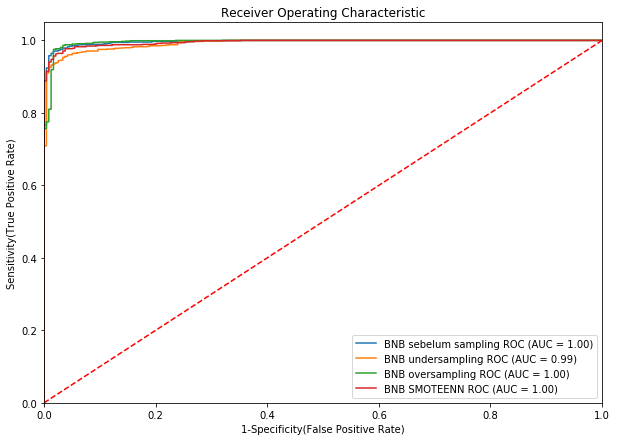

In [88]:
#probs sebelum resampling
bnb = BernoulliNB()
bnb.fit(X_train.toarray(), y_train)
probs_bnb = bern.predict_proba(X_test)
probs_bnb = probs_bnb[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs_bnb)
roc_auc = auc(fpr, tpr)

#probs dari undersampling
bnb.fit(X_rm, y_rm)
probs_rm_bnb = bnb.predict_proba(X_test)
probs_rm_bnb = probs_rm_bnb[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs_rm_bnb)
roc_auc = auc(fpr, tpr)

#probs oversampling
bnb.fit(X_ros, y_ros)
probs_ros_bnb = bnb.predict_proba(X_test)
probs_ros_bnb = probs_ros_bnb[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs_ros_bnb)
roc_auc = auc(fpr, tpr)

#probs both sampling
bnb.fit(X_smt, y_smt)
probs_smt_bnb = bnb.predict_proba(X_test)
probs_smt_bnb = probs_smt_bnb[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs_smt_bnb)
roc_auc = auc(fpr, tpr)

probsNB=[probs_bnb, probs_rm_bnb, probs_ros_bnb, probs_smt_bnb]
models=["BNB sebelum sampling", "BNB undersampling", "BNB oversampling", "BNB SMOTEENN"]

plt.figure(figsize=(10,7))
for idx,m in enumerate(models):
    
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probsNB[idx])
# Calculate Area under the curve to display on the plot
    roc_auc = auc(fpr, tpr)
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (m, roc_auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [97]:
predictions = bnb.predict(X_test)
for i in range(0,5):
    print(listdf[i],predictions[i],y_test[i])
#[print(listdf[i], predictions[i], y_test[i]) for i in range(0, 5)]

KeyError: 0

In [98]:
y_model, y_T = [], []
for x,y in zip(y_test,prediction):
    if x[0]>x[1]:
        y_T.append('Neg')
    else:
        y_T.append('Pos')

    if y[0]>y[1]:
        y_model.append('Neg')
    else:
        y_model.append('Pos')
print(y_model[:5])
print(y_T[:5])

TypeError: 'int' object is not subscriptable

In [53]:
data_test = list(data['Review'][idx_test].values)
#labelsentimen_test = list(data['Sentimen'][idx_test].values)
sentimen_test = y_DL

1328
0


In [52]:
dict_tst = {'test_data': data_test, 'hasil_sentimen':sentimen_test}
prediksi_test = pd.DataFrame(dict_tst)

ValueError: arrays must all be same length